In [22]:
%pylab inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random

Populating the interactive namespace from numpy and matplotlib


In [23]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'dataset/images/'
label_path = 'dataset/revised_labels/'
image_names = os.listdir(label_path)

-21_-123_vh
25_-114_h
-20_-127


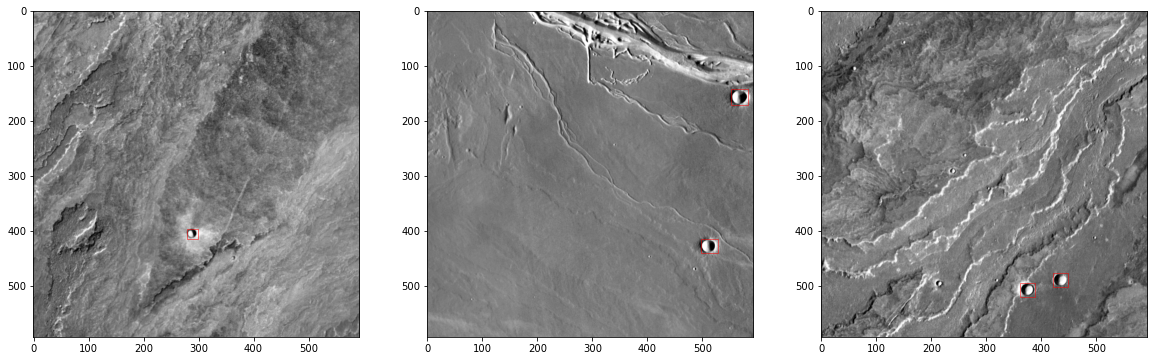

In [24]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    image_name = image_names[i][:-4]
    im = Image.open(image_path + image_name + '.png')
    ax[i].imshow(im, cmap='gray')
    size, size = im.size
    label_name = image_name + '.txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h, id = line.split(' ')
        x = float(x) * size
        y = float(y) * size
        w = float(w) * size
        h = float(h) * size
        x -= w / 2
        y -= h / 2
        rect = patches.Rectangle((x, y), w, h, linewidth=0.5, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    f.close()